In [1]:
from graphdatascience import GraphDataScience
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns

This notebook was run with a free Neo4j sandbox. To run it yourself, log in to https://sandbox.neo4j.com and launch the "Data Science" project. Then, copy the connection information from your sandbox into the cell below.

In [2]:
gds = GraphDataScience("bolt://18.212.51.90:7687", auth=('neo4j', 'generator-milestone-radiuses'))
gds.set_database("neo4j")

# Discover communities

*This section of the notebook was run in advance of the GraphConnect presentation.*

Project a graph of airports and HAS_ROUTE relationships.

In [3]:
G_air, results = gds.graph.project("air-routes", "Airport", 
                                   {"HAS_ROUTE": {"orientation": "UNDIRECTED"}})

In [4]:
results

nodeProjection            {'Airport': {'label': 'Airport', 'properties':...
relationshipProjection    {'HAS_ROUTE': {'orientation': 'UNDIRECTED', 'a...
graphName                                                        air-routes
nodeCount                                                              3503
relationshipCount                                                     92778
projectMillis                                                          2409
Name: 0, dtype: object

Check the count of weakly connected components. Weakly connected components are communities within the graph where all nodes in within the same component are connected by paths.

In [5]:
gds.wcc.stats(G_air)['componentDistribution']

{'p99': 1,
 'min': 1,
 'max': 3292,
 'mean': 16.52358490566038,
 'p90': 1,
 'p50': 1,
 'p999': 3292,
 'p95': 1,
 'p75': 1}

It looks like there are several components of size 1. They aren't very interesting for community detection. Let's make a subgraph that just has the giant connected component.

In [6]:
gds.wcc.mutate(G_air, mutateProperty = "wccComponent")

mutateMillis                                                             4
nodePropertiesWritten                                                 3503
componentCount                                                         212
componentDistribution    {'p99': 1, 'min': 1, 'max': 3292, 'mean': 16.5...
postProcessingMillis                                                   117
preProcessingMillis                                                      0
computeMillis                                                           95
configuration            {'jobId': 'eccfeca5-4a38-44dd-ab19-ca16898a4a4...
Name: 0, dtype: object

In [7]:
component_df = gds.graph.streamNodeProperty(G_air, "wccComponent")

Find the component that has the most nodes.

In [8]:
component_df.value_counts('propertyValue').sort_values(ascending=False)

propertyValue
0       3292
3013       1
2993       1
472        1
941        1
        ... 
3479       1
3480       1
3481       1
3483       1
3490       1
Length: 212, dtype: int64

Record the component ids in the persistent graph on disk.

In [9]:
gds.graph.writeNodeProperties(G_air, ["wccComponent"])

writeMillis                    4617
graphName                air-routes
nodeProperties       [wccComponent]
propertiesWritten              3503
Name: 0, dtype: object

Create a subgraph that has only the connected airports.

In [10]:
G_connected, result = gds.beta.graph.project.subgraph("connected-airports", 
                                                       G_air, 
                                                       f"n.wccComponent = 0", 
                                                       "*")

In [11]:
result

fromGraphName                 air-routes
nodeFilter            n.wccComponent = 0
relationshipFilter                     *
graphName             connected-airports
nodeCount                           3292
relationshipCount                  92778
projectMillis                       1410
Name: 0, dtype: object

Create communities with the Louvain algorithm.

In [12]:
gds.louvain.write(G_connected, writeProperty = "louvainCommunity")

writeMillis                                                           2183
nodePropertiesWritten                                                 3292
modularity                                                        0.593998
modularities             [0.5769704697914203, 0.593551363663195, 0.5939...
ranLevels                                                                3
communityCount                                                          24
communityDistribution    {'p99': 801, 'min': 2, 'max': 801, 'mean': 137...
postProcessingMillis                                                     7
preProcessingMillis                                                     70
computeMillis                                                         7212
configuration            {'maxIterations': 10, 'writeConcurrency': 4, '...
Name: 0, dtype: object

Create communities with the label propagation algorithm.

In [13]:
gds.labelPropagation.write(G_connected, writeProperty = "labelPropCommunity")

writeMillis                                                            703
nodePropertiesWritten                                                 3292
ranIterations                                                            3
didConverge                                                           True
communityCount                                                           2
communityDistribution    {'p99': 3193, 'min': 99, 'max': 3193, 'mean': ...
postProcessingMillis                                                     7
preProcessingMillis                                                      3
computeMillis                                                         1490
configuration            {'maxIterations': 10, 'writeConcurrency': 4, '...
Name: 0, dtype: object

K-Means isn't available in the Neo4j sandboxes yet, so let's stream embeddings and calculate K-Means in Python.

In [14]:
embedding_df = gds.fastRP.stream(G_connected, embeddingDimension=64)

We're using the kmeans algorithm from scikit learn here.

In [15]:
kmeans = KMeans(n_clusters = 6)

In [16]:
kmeans_clusters = kmeans.fit_transform(list(embedding_df['embedding']))

In [17]:
embedding_df['cluster'] = kmeans.labels_

How many nodes ended up in each cluster?

In [18]:
embedding_df['cluster'].value_counts()

1    766
0    659
2    584
5    551
4    454
3    278
Name: cluster, dtype: int64

What is the silhouette score for the k-means clusters?

In [19]:
silhouette_score(list(embedding_df['embedding']), embedding_df['cluster'])

0.2683358419130647

Now we'll write the K-Means clusters back to Neo4j. To do that, turn the dataframe into a list of dictionaries.

In [20]:
kmeans_dict = embedding_df[['nodeId', 'cluster']].to_dict("records")

Pass the list of dictionaries as a parameter to a Cypher query.

In [21]:
gds.run_cypher("""
UNWIND $kmeansAssigments as row
MATCH (n) where id(n) = row['nodeId']
SET n.kMeansCommunity = row['cluster']
""", {"kmeansAssigments": kmeans_dict})

""


Drop the old graph projections.

In [22]:
gds.graph.drop(G_air)
gds.graph.drop(G_connected)

graphName                                           connected-airports
database                                                         neo4j
memoryUsage                                                           
sizeInBytes                                                         -1
nodeCount                                                         3292
relationshipCount                                                92778
configuration        {'relationshipProperties': [], 'creationTime':...
density                                                       0.008564
creationTime                       2022-06-29T13:27:38.077548000+00:00
modificationTime                   2022-06-29T13:27:39.489703000+00:00
schema               {'graphProperties': {}, 'relationships': {'HAS...
Name: 0, dtype: object

Create a new graph projection that contains only connected airports and includes all three of our community ids as node properties.

Start by adding a new ConnectedAirport label to airports in component 0.

In [23]:
gds.run_cypher("""MATCH (a:Airport {wccComponent:0}) SET a:ConnectedAirport RETURN count(a) as airportCount""")

,airportCount
0,3292


Create the new projection.

In [24]:
G_air, results = gds.graph.project("air-routes", 
                                   {"ConnectedAirport": 
                                        {"properties": ["louvainCommunity", "labelPropCommunity", "kMeansCommunity"]}}, 
                                   {"HAS_ROUTE": {"orientation": "UNDIRECTED"}})

Create a dataframe with the node counts for each community.

In [25]:
community_df = gds.graph.streamNodeProperties(G_air, ["louvainCommunity", "labelPropCommunity", "kMeansCommunity"])
community_df = community_df.groupby(['nodeProperty', 'propertyValue']).count()
community_df.reset_index(inplace=True)
community_df.rename({"nodeProperty": "community_property", "propertyValue": "community", "nodeId":"node_count"}, 
                    axis=1, inplace=True)

Write a function to create a subgraph for a community property. 

In [26]:
def create_subgraph(community_property, community_id):
    subgraph_name = f"{community_property}_{community_id}"
    subgraph_filter = f"n.{community_property} = {community_id}"
    subgraph, result = gds.beta.graph.project.subgraph(subgraph_name, 
                                                       G_air,
                                                       subgraph_filter, 
                                                       "*")
    return subgraph

Run the function for each row in the community_df data frame.

In [27]:
community_df['subgraph'] = community_df.apply(lambda row: 
                                              create_subgraph(row['community_property'], row['community']),
                                              axis=1)  

# Setup complete
Before the session, I created communities from a graph of airports and air routes. The dataframe below contains the community property, community ID, and a node count for each community in the graph. It also contains a column which holds a python graph object for each community.

In [28]:
community_df

,community_property,community,node_count,subgraph
0,kMeansCommunity,0,659,<graphdatascience.graph.graph_object.Graph obj...
1,kMeansCommunity,1,766,<graphdatascience.graph.graph_object.Graph obj...
2,kMeansCommunity,2,584,<graphdatascience.graph.graph_object.Graph obj...
3,kMeansCommunity,3,278,<graphdatascience.graph.graph_object.Graph obj...
4,kMeansCommunity,4,454,<graphdatascience.graph.graph_object.Graph obj...
5,kMeansCommunity,5,551,<graphdatascience.graph.graph_object.Graph obj...
6,labelPropCommunity,8629,3193,<graphdatascience.graph.graph_object.Graph obj...
7,labelPropCommunity,8634,99,<graphdatascience.graph.graph_object.Graph obj...
8,louvainCommunity,709,709,<graphdatascience.graph.graph_object.Graph obj...
9,louvainCommunity,810,175,<graphdatascience.graph.graph_object.Graph obj...


# Conductance
What percentage of relationships that start in one cluster end in a different cluster?

Call the conductance algorithm for each community property in G_air and collect the results.

In [29]:
community_properties = ['louvainCommunity', 'labelPropCommunity', 'kMeansCommunity']

In [30]:
conductance_dfs = []
for prop in community_properties:
    conductance_df = gds.alpha.conductance.stream(G_air, communityProperty=prop)
    conductance_df['community_property'] = prop
    conductance_dfs.append(conductance_df)
conductance_df = pd.concat(conductance_dfs)

In [31]:
conductance_df

,community,conductance,community_property
0,709,0.114018,louvainCommunity
1,810,0.438733,louvainCommunity
2,1093,0.125000,louvainCommunity
3,1097,0.212121,louvainCommunity
4,1098,0.250000,louvainCommunity
5,1100,0.073171,louvainCommunity
6,1104,0.151515,louvainCommunity
7,1106,0.250000,louvainCommunity
8,1108,0.085714,louvainCommunity
9,1182,0.288221,louvainCommunity


In [32]:
community_df = community_df.merge(conductance_df, on=['community_property', 'community'])

Plot the conductance versus the node count for each community. It seems that the largest communities are big enough to be mostly self-contained, while the smaller communities have a range of conductance scores.

<AxesSubplot:xlabel='node_count', ylabel='conductance'>

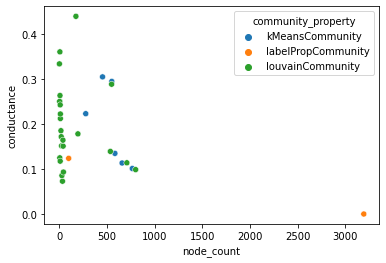

In [33]:
sns.scatterplot(x="node_count", y="conductance", hue="community_property", data=community_df)

# Modularity
What is the difference between the fraction of within-cluster relationships that we observe versus what we would see if nodes kept the same degree, but the relationships were connected randomly? We can calculate this for the Louvain communities, but there's not a quick way to calculate it for the others.

In [34]:
gds.louvain.stats(G_air)

modularity                                                        0.595115
modularities             [0.5729813840322497, 0.5945951372854718, 0.595...
ranLevels                                                                3
communityCount                                                          22
communityDistribution    {'p99': 799, 'min': 2, 'max': 799, 'mean': 149...
postProcessingMillis                                                     4
preProcessingMillis                                                      0
computeMillis                                                         3594
configuration            {'maxIterations': 10, 'seedProperty': None, 'c...
Name: 0, dtype: object

# Clustering Coefficient
What is the probability that two neighbors of a node also have a relationship between them?

Call the localClusteringCoefficient algorithm for each subgraph in the community_df data frame.

In [35]:
community_df['average_clustering_coefficient'] = (
    community_df['subgraph'].map(lambda x: gds.localClusteringCoefficient.stats(x)['averageClusteringCoefficient']))

In [36]:
community_df

,community_property,community,node_count,subgraph,conductance,average_clustering_coefficient
0,kMeansCommunity,0,659,<graphdatascience.graph.graph_object.Graph obj...,0.113537,0.570170
1,kMeansCommunity,1,766,<graphdatascience.graph.graph_object.Graph obj...,0.101364,0.498627
2,kMeansCommunity,2,584,<graphdatascience.graph.graph_object.Graph obj...,0.134834,0.541606
3,kMeansCommunity,3,278,<graphdatascience.graph.graph_object.Graph obj...,0.222910,0.375434
4,kMeansCommunity,4,454,<graphdatascience.graph.graph_object.Graph obj...,0.304503,0.452076
5,kMeansCommunity,5,551,<graphdatascience.graph.graph_object.Graph obj...,0.294421,0.196446
6,labelPropCommunity,8629,3193,<graphdatascience.graph.graph_object.Graph obj...,0.000443,0.479254
7,labelPropCommunity,8634,99,<graphdatascience.graph.graph_object.Graph obj...,0.123867,0.153943
8,louvainCommunity,709,709,<graphdatascience.graph.graph_object.Graph obj...,0.114018,0.499692
9,louvainCommunity,810,175,<graphdatascience.graph.graph_object.Graph obj...,0.438733,0.538552


Plot the clustering coefficient versus cluster size. In general, it seems that larger clusters tend to also have a higher clustering coefficient.

<AxesSubplot:xlabel='node_count', ylabel='average_clustering_coefficient'>

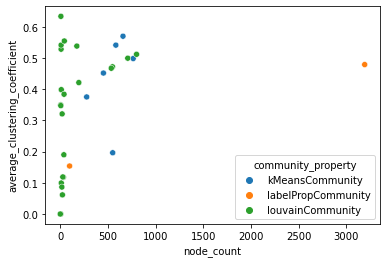

In [37]:
sns.scatterplot(x="node_count", y="average_clustering_coefficient", hue="community_property", data=community_df)

# What is a good example of a member of each cluster?

Write a function that applies a centrality score to a subgraph and gets back the top few airports IDs and the average degree centrality for the cluster.

In [38]:
def get_central_airports(row):
    subgraph_name = row['subgraph'].name()
    top_airport_df = gds.run_cypher("""
    call gds.degree.stream($subgraphName) yield nodeId, score
    WITH gds.util.asNode(nodeId) as a, score
    ORDER BY score desc
    RETURN collect(a.descr)[..3] as airportDescription, avg(score) as averageDegree
    """, {"subgraphName": subgraph_name})
    return top_airport_df.iloc[0].tolist()

In [39]:
centrality_df = community_df.apply(get_central_airports, axis=1, result_type='expand')

In [40]:
centrality_df.columns = ['central_airports', 'average_degree']

In [41]:
community_df = pd.concat([community_df, centrality_df], axis=1)

In [42]:
community_df

,community_property,community,node_count,subgraph,conductance,average_clustering_coefficient,central_airports,average_degree
0,kMeansCommunity,0,659,<graphdatascience.graph.graph_object.Graph obj...,0.113537,0.570170,"[Dallas/Fort Worth International Airport, Chic...",30.804249
1,kMeansCommunity,1,766,<graphdatascience.graph.graph_object.Graph obj...,0.101364,0.498627,"[Munich International Airport, London Stansted...",47.475196
2,kMeansCommunity,2,584,<graphdatascience.graph.graph_object.Graph obj...,0.134834,0.541606,"[Beijing Capital International Airport, Shangh...",22.897260
3,kMeansCommunity,3,278,<graphdatascience.graph.graph_object.Graph obj...,0.222910,0.375434,"[Sao Paulo, Guarulhos - Governador Andras Fran...",9.028777
4,kMeansCommunity,4,454,<graphdatascience.graph.graph_object.Graph obj...,0.304503,0.452076,"[Dubai International Airport, Doha, Hamad Inte...",12.859031
5,kMeansCommunity,5,551,<graphdatascience.graph.graph_object.Graph obj...,0.294421,0.196446,"[Port Moresby Jacksons International Airport, ...",2.983666
6,labelPropCommunity,8629,3193,<graphdatascience.graph.graph_object.Graph obj...,0.000443,0.479254,"[Frankfurt am Main, Paris Charles de Gaulle, I...",28.940182
7,labelPropCommunity,8634,99,<graphdatascience.graph.graph_object.Graph obj...,0.123867,0.153943,"[Anchorage Ted Stevens, Bethel Airport, Nome A...",2.929293
8,louvainCommunity,709,709,<graphdatascience.graph.graph_object.Graph obj...,0.114018,0.499692,"[Beijing Capital International Airport, Shangh...",19.870240
9,louvainCommunity,810,175,<graphdatascience.graph.graph_object.Graph obj...,0.438733,0.538552,"[Moscow, Domodedovo International Airport, Pul...",11.542857


## Summarize properties of the clusters

In [43]:
def get_continent_percent(community_property):
    continent_df = gds.run_cypher(f"""MATCH (a:ConnectedAirport)-[:ON_CONTINENT]->(c)
    WITH a.{community_property} as community, c.name as continent, count(*) as airportCount
    WITH community, collect(continent) as continents, collect(airportCount) as counts, 
    sum(airportCount) as totalAirports
    UNWIND range(0, size(continents) - 1) as i
    RETURN community,  continents[i] as continent, 
    round(100.0 * counts[i]/totalAirports, 1) as percent_on_continent""")
    continent_df = continent_df.pivot(index="community", columns="continent", values ="percent_on_continent")
    continent_df.reset_index(inplace=True)
    continent_df.fillna(0, inplace=True)
    continent_df['community_property'] = community_property
    return continent_df

In [44]:
continent_dfs = [get_continent_percent(prop) for prop in community_properties]
continent_df = pd.concat(continent_dfs)

In [45]:
community_df = community_df.merge(continent_df, on=['community_property', 'community'])

In [46]:
community_df

,community_property,community,node_count,subgraph,conductance,average_clustering_coefficient,central_airports,average_degree,AF,AS,EU,NA,OC,SA
0,kMeansCommunity,0,659,<graphdatascience.graph.graph_object.Graph obj...,0.113537,0.570170,"[Dallas/Fort Worth International Airport, Chic...",30.804249,0.2,0.0,0.0,99.2,0.2,0.5
1,kMeansCommunity,1,766,<graphdatascience.graph.graph_object.Graph obj...,0.101364,0.498627,"[Munich International Airport, London Stansted...",47.475196,9.8,18.0,72.1,0.1,0.0,0.0
2,kMeansCommunity,2,584,<graphdatascience.graph.graph_object.Graph obj...,0.134834,0.541606,"[Beijing Capital International Airport, Shangh...",22.897260,0.0,83.6,0.0,0.0,16.4,0.0
3,kMeansCommunity,3,278,<graphdatascience.graph.graph_object.Graph obj...,0.222910,0.375434,"[Sao Paulo, Guarulhos - Governador Andras Fran...",9.028777,0.0,0.0,0.0,3.6,0.0,96.4
4,kMeansCommunity,4,454,<graphdatascience.graph.graph_object.Graph obj...,0.304503,0.452076,"[Dubai International Airport, Doha, Hamad Inte...",12.859031,44.3,55.3,0.2,0.0,0.0,0.2
5,kMeansCommunity,5,551,<graphdatascience.graph.graph_object.Graph obj...,0.294421,0.196446,"[Port Moresby Jacksons International Airport, ...",2.983666,6.0,6.9,5.3,48.3,31.9,1.6
6,labelPropCommunity,8629,3193,<graphdatascience.graph.graph_object.Graph obj...,0.000443,0.479254,"[Frankfurt am Main, Paris Charles de Gaulle, I...",28.940182,9.7,28.7,18.2,26.1,8.5,8.8
7,labelPropCommunity,8634,99,<graphdatascience.graph.graph_object.Graph obj...,0.123867,0.153943,"[Anchorage Ted Stevens, Bethel Airport, Nome A...",2.929293,0.0,0.0,0.0,100.0,0.0,0.0
8,louvainCommunity,709,709,<graphdatascience.graph.graph_object.Graph obj...,0.114018,0.499692,"[Beijing Capital International Airport, Shangh...",19.870240,0.0,73.2,0.0,0.0,26.8,0.0
9,louvainCommunity,810,175,<graphdatascience.graph.graph_object.Graph obj...,0.438733,0.538552,"[Moscow, Domodedovo International Airport, Pul...",11.542857,0.0,62.3,37.7,0.0,0.0,0.0


## Clean up in-memory graphs

In [47]:
for g in community_df['subgraph']:
    gds.graph.drop(g)

In [48]:
community_df.drop('subgraph', axis=1, inplace=True)

In [49]:
gds.graph.drop(G_air)

graphName                                                   air-routes
database                                                         neo4j
memoryUsage                                                           
sizeInBytes                                                         -1
nodeCount                                                         3292
relationshipCount                                                92778
configuration        {'relationshipProjection': {'HAS_ROUTE': {'ori...
density                                                       0.008564
creationTime                       2022-06-29T13:28:09.898072000+00:00
modificationTime                   2022-06-29T13:28:11.196958000+00:00
schema               {'graphProperties': {}, 'relationships': {'HAS...
Name: 0, dtype: object

In [50]:
gds.graph.list()

,degreeDistribution,graphName,database,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema
